<a href="https://colab.research.google.com/github/anoopsanka/retinal_oct/blob/main/notebooks/OCT_simclr_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/anoopsanka/retinal_oct

Cloning into 'retinal_oct'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (27/27), done.
remote: Total 468 (delta 14), reused 20 (delta 7), pack-reused 434
Receiving objects: 100% (468/468), 254.21 MiB | 19.74 MiB/s, done.
Resolving deltas: 100% (255/255), done.


In [2]:
%%capture
# needed to use rotate....
!pip install -U tensorflow_addons
!pip install envyaml

In [3]:
%cd retinal_oct

/content/retinal_oct


In [4]:
import tensorflow_datasets as tfds
from core.datasets import RetinaDataset

In [5]:
ds_train_full, ds_train_info = tfds.load('RetinaDataset', split='train', as_supervised=True, with_info=True)
ds_test  = tfds.load('RetinaDataset', split='test', shuffle_files=False, as_supervised=True)

Shuffling and writing examples to /root/tensorflow_datasets/retina_dataset/1.0.0.incompleteH9K530/retina_dataset-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/retina_dataset/1.0.0.incompleteH9K530/retina_dataset-test.tfrecord


Dataset retina_dataset downloaded and prepared to /root/tensorflow_datasets/retina_dataset/1.0.0. Subsequent calls will reuse this data.


In [7]:
import os
import random
import numpy as np
import tensorflow as tf

# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

In [16]:
from datasets.data_augmentation import train_classification_aug
from models.model_utils.lr_schedule import WarmUpAndCosineDecay
from models import simclr_model
import tensorflow_addons as tfa

# Pull Sample Weights from Wandb
https://wandb.ai/hisunnytang/OCT-keras-SimCLR


97 % contrastive accuracy & ~ 90 % supervised accuracy
- https://wandb.ai/hisunnytang/OCT-keras-SimCLR/runs/1ipksk06/overview?workspace=user-hisunnytang

In [8]:
%%capture
pip install wandb

In [9]:
import wandb
api = wandb.Api()
run = api.run("hisunnytang/OCT-keras-SimCLR/1ipksk06")
run.file("weights.108-0.97.hdf5").download()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<_io.TextIOWrapper name='./weights.108-0.97.hdf5' mode='r' encoding='UTF-8'>

In [10]:
config = run.config

In [11]:
config

{'IMG_SIZE': 128,
 'batch_size': 128,
 'epochs': 120,
 'ft_proj_selector': 0,
 'hidden_norm': True,
 'learning_rate': 0.01,
 'learning_rate_scaling': 'linear',
 'num_classes': 4,
 'num_examples': 83489,
 'num_proj_layers': 3,
 'proj_head_mode': 'nonlinear',
 'proj_out_dim': 128,
 'resnet_depth': 18,
 'resnet_se_ratio': 0,
 'resnet_sk_ratio': 0,
 'resnet_width_multiplier': 1,
 'temperature': 1,
 'use_blur': True,
 'warmup_epochs': 10}

In [21]:
from core.models.simclr_model import Pretrained_SimCLR_Model
from core.datasets.data_augmentation import train_classification_aug
model_loadweights = Pretrained_SimCLR_Model()

In [22]:
input_shape_base   = (None, config["IMG_SIZE"], config["IMG_SIZE"], 3)
input_shape_simclr = (None, config["IMG_SIZE"], config["IMG_SIZE"], 6)
model_loadweights.base_model.build(input_shape_base)
model_loadweights.build(input_shape_simclr)
model_loadweights.summary()
model_loadweights.load_weights('weights.108-0.97.hdf5')

Model: "pretrained__sim_clr__model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet_1 (Resnet)            multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head_1 (Projectio multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________


In [23]:
def train_data_aug(img, lb):
  xs = []
  for _ in range(2):
    xs.append(train_classification_aug(img, lb, img_size = 128)[0])
  img = tf.concat(xs, -1)
  return img, tf.one_hot(lb, 4)

def val_data_aug(img, lb):
  xs = []
  for _ in range(2):
    xs.append(train_classification_aug(img, lb, img_size = 128)[0])
  img = tf.concat(xs, -1)
  return img, tf.one_hot(lb, 4)

# pull the based layers 

In [16]:
def create_classification_model(base_model,):
  input_layer = tf.keras.Input((config["IMG_SIZE"], config["IMG_SIZE"], 3))
  model_loadweights.layers[0].trainable = False
  resnet_output = model_loadweights.layers[0](input_layer)
  pooling_output = tf.keras.layers.GlobalAveragePooling2D()(resnet_output)
  dense1 = tf.keras.layers.Dense(128, activation='relu')(pooling_output)
  output = tf.keras.layers.Dense(4,  activation='softmax')(dense1)
  classification_model = tf.keras.Model(input_layer, output)
  classification_model.summary()
  return classification_model

In [17]:
def subseting_data(train_percent=10, val_percent= 10):
  ds_train_partial = tfds.load('RetinaDataset', split=f'train[:{train_percent}%]', as_supervised=True)
  ds_val_partial   = tfds.load('RetinaDataset', split=f'train[-{val_percent}%:]',  as_supervised=True)
  return ds_train_partial, ds_val_partial

In [18]:
def train_augment_one_image_only(img, lb):
  img = train_classification_aug(img, lb, img_size = 128)[0]
  return img, tf.one_hot(lb, 4)

def validiation_one_image_only(img, lb):
  img = tf.cast(img, tf.float32)/ 255.
  img = tf.image.resize(img, (128,128))
  return img, tf.one_hot(lb, 4)

In [19]:
def train_on_percentage_data(train_percentage = 10, 
                             batch_size=32, 
                             epochs=50,
                             lr = 1e-3):
  classification_model = create_classification_model( model_loadweights )

  ds_train, ds_val = subseting_data(train_percentage)

  # define callbacks
  model_name = 'train_prop' + str(train_percentage) + '_'
  cb_earlystopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5,)
  cb_checkpointing = tf.keras.callbacks.ModelCheckpoint(  model_name+ "weights.{epoch:02d}-{val_loss:.2f}.hdf5" )
  callbacks = [cb_earlystopping, ]# cb_checkpointing]

  # compile the model
  optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
  classification_model.compile(optimizer= optimizer, 
                               loss = 'categorical_crossentropy', 
                               metrics='accuracy')

  # train it 
  history = classification_model.fit(ds_train.map(train_augment_one_image_only).batch(batch_size), 
                                     validation_data = ds_val.map(train_augment_one_image_only).batch(batch_size),
                                     callbacks = callbacks,
                                     epochs=epochs)
  return classification_model, history


In [ ]:
model_1percent, history_1percent = train_on_percentage_data(1, epochs=50)

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet_1 (Resnet)            (None, 4, 4, 512)         11190464  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 128)               65664     
_________________________________________________________________
dense_11 (Dense)             (None, 4)                 516       
Total params: 11,256,644
Trainable params: 66,180
Non-trainable params: 11,190,464
_________________________________________________________________
Epoch 1/50
27/27 [==============================] - 47s 2s/step - loss: 1.0593 - accuracy: 0.5802 - val_loss

# Extract the representation layer

In [102]:
input  = tf.keras.Input(shape=(128,128,3)) 
output = model_loadweights.layers[0](input)
output = model_loadweights.layers[1](output)
model_representation = tf.keras.Model(input, output)

In [103]:
model_representation.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
resnet (Resnet)              (None, 4, 4, 512)         11190464  
Total params: 11,190,464
Trainable params: 0
Non-trainable params: 11,190,464
_________________________________________________________________


In [104]:
model_representation.compile()

In [ ]:
model_representation(tf.zeros((32,128,128,3)))

In [114]:
def get_one_image_only(img, lb):
  img = tf.cast(img, tf.float32)/ 255.
  img = tf.image.resize(img, (128,128))
  return img

testset_repr = []
for d in ds_test.map(get_one_image_only).batch(32):
  testset_repr.append(model_representation(d).numpy())

In [116]:
testset_repr = np.vstack(testset_repr)

In [122]:
print(repr.shape)

(968, 8192)


In [128]:
repr = testset_repr.reshape(968,-1)

output = PCA(n_components=3).fit_transform(repr)

In [129]:
model = PCA(n_components=3).fit(repr)

In [130]:
model.explained_variance_ratio_

array([0.11995694, 0.09090752, 0.06875641], dtype=float32)

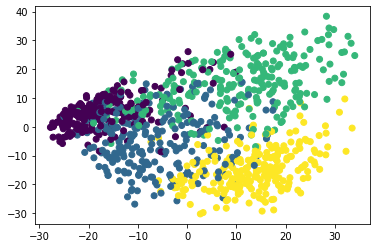

In [121]:
plt.scatter(output[:,0], output[:,1], c = y_true)

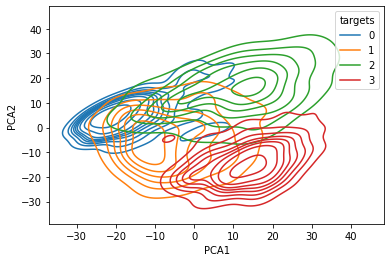

In [124]:
import pandas as pd
import seaborn as sns
df = pd.DataFrame(output, columns=['PCA1', 'PCA2'])
df['targets'] = y_true
sns.kdeplot(x ='PCA1', y='PCA2', data= df, hue='targets', palette= sns.color_palette()[0:4] )

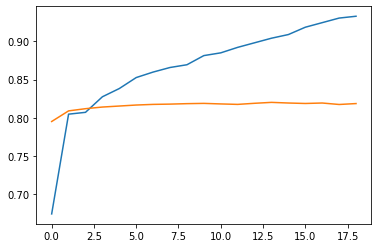

In [30]:
import matplotlib.pyplot as plt

plt.plot(history_1percent.history['accuracy'])
plt.plot(history_1percent.history['val_accuracy'])

In [108]:
model_1percent.evaluate(ds_test.map(train_augment_one_image_only).batch(32))

31/31 [==============================] - 4s 137ms/step - loss: 0.4408 - accuracy: 0.8543


[0.44077786803245544, 0.8543388247489929]

In [38]:
y_true = np.hstack([l for l in ds_test.map(lambda img, lb: lb)])
y_pred = model_1percent.predict(ds_test.map(train_augment_one_image_only).batch(32))

In [141]:
model_loadweights.compile()
y_pred = []
for X, lb in ds_test.map(train_augment_one_image_only).batch(32):
  rep, logits = model_loadweights(X, training=False)
  y_pred.append(logits.numpy())

In [156]:
def get_dense_output(model):
  input = tf.keras.Input((128,128,3))
  output = input
  for l in model.layers[:-1]:
    output = l(output)
  return tf.keras.Model(input,output)

In [167]:
model_1percent_dense.summary()

Model: "model_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
input_1 (InputLayer)         multiple                  0         
_________________________________________________________________
resnet (Resnet)              (None, 4, 4, 512)         11190464  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               65664     
Total params: 11,256,128
Trainable params: 65,664
Non-trainable params: 11,190,464
_________________________________________________________________


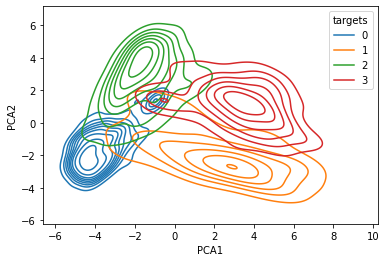

In [165]:
model_1percent_dense = get_dense_output(model_1percent)

rep_1percent = []
for img, lb in ds_test.map(train_augment_one_image_only).batch(32):
  rep1 = model_1percent_dense(img)
  rep_1percent.append(rep1.numpy())

pca_1percent = PCA(n_components=2).fit_transform( np.vstack(rep_1percent))

import pandas as pd
import seaborn as sns
df = pd.DataFrame(pca_1percent, columns=['PCA1', 'PCA2'])
df['targets'] = y_true
sns.kdeplot(x ='PCA1', y='PCA2', data= df, hue='targets', palette= sns.color_palette()[0:4] )

In [160]:
model_1percent_dense = get_dense_output(model_

rep_1percent = []
for img, lb in ds_test.map(train_augment_one_image_only).batch(32):
  rep1 = model_1percent_dense(img)
  rep_1percent.append(rep1.numpy())

pca_1percent = PCA(n_components=2).fit_transform( np.vstack(rep_1percent))

import pandas as pd
import seaborn as sns
df = pd.DataFrame(pca_1percent, columns=['PCA1', 'PCA2'])
df['targets'] = y_true
sns.kdeplot(x ='PCA1', y='PCA2', data= df, hue='targets', palette= sns.color_palette()[0:4] )

In [148]:
y_pred_raw = np.vstack(y_pred).argmax(axis=-1)

sum(y_true == y_pred_raw) / len(y_true)

0.890495867768595

In [150]:
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
precision, recall, fbeta_score, support = precision_recall_fscore_support( y_true, y_pred_raw )

In [151]:
precision.

0.8998009790027487

In [152]:
recall.mean()

0.890495867768595

In [153]:
fbeta_score.mean()

0.8903004730966522